In [1]:
import math
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["PATH"] += os.pathsep + r"C:\Users\AChakhnashvili\AppData\Local\Graphviz-10.0.1-win64\bin"
os.environ["PATH"] += os.pathsep + r"C:\Users\AChakhnashvili\AppData\Local\Graphviz-10.0.1-win64\bin\dot.exe"

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
xs = np.arange(-5, 5, .25)
ys = f(xs)

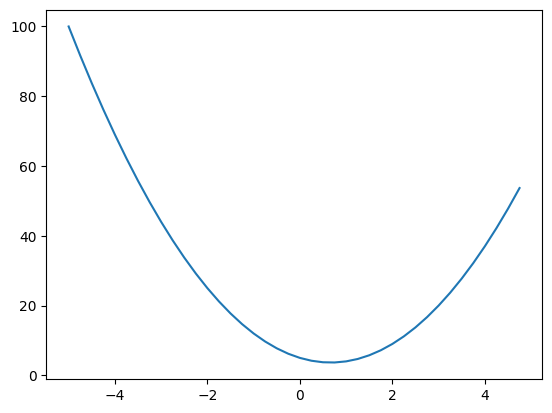

In [5]:
plt.plot(xs, ys)

In [6]:
h = 0.0001
x = 3
f(x)

20

In [7]:
(f(x+h)-f(x))/h

14.000300000063248

In [8]:
# Let's get more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
# Let's get more complex

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
h = 0.000001
a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.9999969999999996
slope -3.000000000419334


In [176]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None      # by  default, it does nothing. This will be a case for the leaf node
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad # it should logically be = and not +=. += handles when one node is referenced more than once. a + a for example
            other.grad += 1.0 * out.grad
        out._backward = _backward   # we don't define function, because it returns nothing. we just want to store the function

        return out
    def __radd__(self, other):
        return self + other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self: __mul__ will throw error if self is int and right is Value. This reverses the operation and handles that error
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other **-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)        
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self): # this implements topological sort that is defined below
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = "d"
f = Value(-2.0, label='f')
L = d * f; L.label = "L"
L

Value(data=-8.0)

In [12]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [13]:
L._op

'*'

In [14]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name= uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad,), shape = 'record')

        if n._op:
            dot.node(name = uid + n._op, label = n._op)

            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

We are always finding partial derivative for Loss. So we are interested in dL/dd, dL/df, dL/dc etc. This will give us what kind of change each node cause to the loss. 

for example:
dL/dd = f
L = d * f
(f(x+h) = f(x))/h
((d+h)*f - d*f)/h
(d*f + h*f - d*f)/h = f

**The important thing to remember is that we are interested in how the tiny change in each element of the function affects its output. So when it is multiplication or plus or any activation function, what we're interested in how each of the elements in this function affect the output node. That's why we are deriving the wrt to each element.**

several things to remember abotut backprop:
- loss' derivative wrt itself is 1
- chain rule: derivative wrt the loss is multiplication of local derivative on the its output's derivative wrt loss. If we know the function's influence on the its output, and output's influence on the loss, it makes sense that we know function's effect on the Loss, that is the multiplication of those two numbers. 
- in each ._backward() we update the grad of the nodes that went into the function, not the output. That's because gradient is the effect of the inputs on the output, so during backprop, inputs should be updated(I got confused once why and how previous nodes where updated and this is a note for that)
- plus sign is just a derivative distributor, it's derivative will be the same as it's next element. 

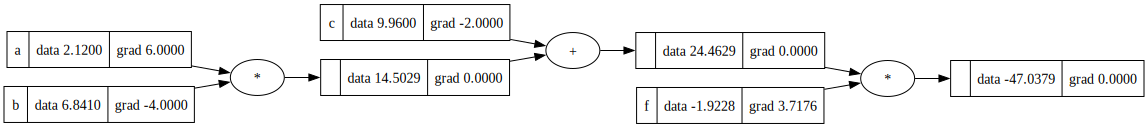

In [43]:
draw_dot(L)

In [38]:
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0

In [39]:
c.grad = -2.0
e.grad = -2.0

In [40]:
f.grad = d.data
d.grad = f.data
L.grad = 1

In [41]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad
e.data += 0.01 * e.grad
f.data += 0.01 * f.grad

In [42]:
e = a * b
d = e + c
L = d * f

print(L.data)

-47.03788968608001


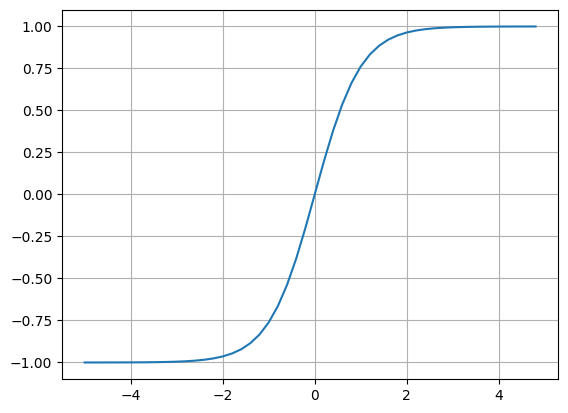

In [21]:
plt.plot(np.arange(-5, 5, .2), np.tanh(np.arange(-5, 5, .2))); plt.grid();

In [132]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881, label='b')

# x1*w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1w1" 
x2w2 = x2*w2; x2w2.label = "x2w2" 

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

o.backward()

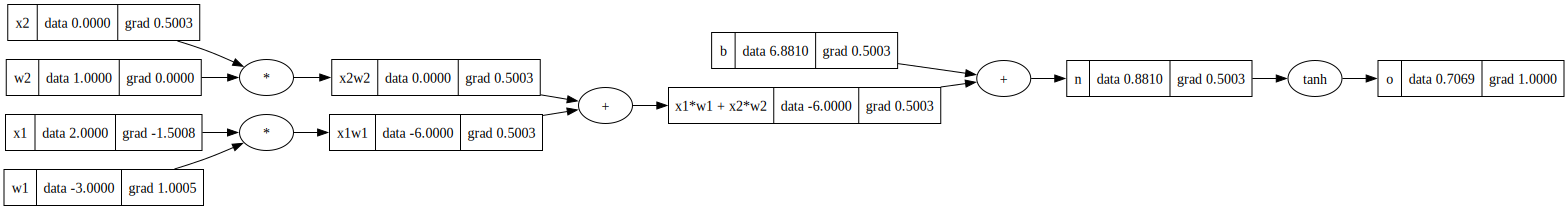

In [133]:
draw_dot(o)

In [144]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881, label='b')

# x1*w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1w1" 
x2w2 = x2*w2; x2w2.label = "x2w2" 

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = "n"

# ------------ breaking down tanh into exp
e = (2 * n).exp(); e.label = "e"
o = (e - 1) / (e + 1); o.label = "o"
# ------------

o.backward()

the main point of this demonstration is that the implementation of the class is totally  up to us. The only thing that matters is that we can do forward and backward pass

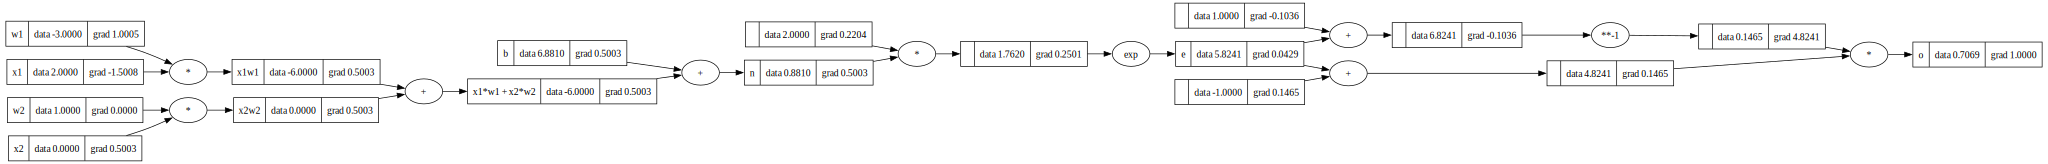

In [145]:
draw_dot(o)

### automatic backprop
last thing is to stop asking ._backward() manually. 

To achieve this, we don't want to call ._backward() on a node until we have done everything after it. We have to get full dependencies, eveything it depends on to propagate before we continute backpropagation.

This ordering of graphs can be achieved using ***topological sort***. It is a laying out of a graph so that edges go only from the left to right.

In [126]:
o.backward()

starting from the root, in our case last item o, we trace all of its children and lay out from left to right. what is left is to call ._backward() on each of them in the topological order

### implementing ._backward() on node level

first time we need to initialize the gradient

In [85]:
o.grad = 1.0

by default backward is an empty function. when we trigger it using brackets, the info about updating the gradients of the previous nodes saved in node.backward is triggered

In [86]:
o._backward()

In [88]:
n._backward()

In [89]:
b._backward()

In [92]:
x1w1x2w2._backward()

In [93]:
x1w1._backward()

In [94]:
x2w2._backward()

### fully manual backprop

In [72]:
w2.grad = x2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad

In [70]:
x2.grad = w2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad

In [69]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [68]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [67]:
n.grad = 0.5

In [66]:
o.grad = 1.0

In [32]:
1 - o.data**2

0.5002642007944019

## micrograd but in pytorch

In [151]:
import torch

In [166]:
x1 = torch.Tensor([2.0]).double()                        ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                        ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                       ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                        ; w2.requires_grad = True
b = torch.Tensor([6.88137]).double()                     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b                                    
o = torch.tanh(n)                                        

print(o.data.item())
o.backward()

print("---")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())

0.7071050214706146
---
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w2 0.0


pytorch's API matches ours, with the only difference that it is much more efficient while working with the tensors. Our micrograd only works with scalars

## Building nn library

In [170]:
import random

In [177]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum(wi*xi for wi, xi in list(zip(self.w, x))) + self.b
        out = act.tanh()
        return out
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9964728786403472)